# CS2 Processing Report

Package versions.

In [1]:
import paramaterial as pam
from paramaterial import DataSet, DataItem, ModelSet
from paramaterial.models import ramberg
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

print(pam.__version__)
print(pd.__version__)
print(sns.__version__)
print(mpl.__version__)

0.0.11
1.4.4
0.11.2
3.5.3


Extract info from the filenames and make the info table.

In [2]:
info_lists = [[filename] + filename.split('_')[:4] for filename in os.listdir('data/01 raw data')]
info_table = pd.DataFrame(info_lists,
                          columns=['old_filename', 'test_type', 'temperature', 'lot', 'number']
                          ).sort_values(by='test_type', ascending=False)

Add a unique test ID column.

In [3]:
info_table['test_id'] = [f'test_ID_{i + 1:03d}' for i in range(len(info_table))]
info_table = info_table.set_index('test_id').reset_index()  # move the test_id column to the far left

Rename test types and get subset of lots.

In [4]:
info_table['test_type'] = info_table['test_type'].replace('T', 'UT')
info_table['test_type'] = info_table['test_type'].replace('P', 'PST')
info_table = info_table[info_table['lot'].isin(list('FGHI'))]

Add the information from the paper, and convert the temperatures to numbers.

In [5]:
info_table['rate'] = 8.66e-4  # units (/s)
info_table['temperature'] = pd.to_numeric(info_table['temperature'])
info_table = info_table[info_table['temperature'] != 100]  #??

### Format the data files.
In this example, the files are already in .csv format. We just check that the column headers are the same and that there are no duplicates, then rename the files by test id.

Check column headers, uniqueness.

In [6]:
pam.preparing.check_column_headers('data/01 raw data')
pam.preparing.check_for_duplicate_files('data/01 raw data')

Checking column headers...
First file headers:
	['Strain', 'Stress_MPa']
Headers in all files are the same as in the first file, except for None.
Checking for duplicate files...
No duplicate files found in "data/01 raw data".


Write the prepared data and rename the files by test id. Also write the prepared info table.

In [7]:
pam.preparing.copy_data_and_rename_by_test_id(data_in='data/01 raw data', data_out='data/01 prepared data',
                                              info_table=info_table)
info_table.to_excel('info/01 prepared info.xlsx', index=False)

Copied 74 files in data/01 raw data to data/01 prepared data.


In [8]:
def make_strain_percent(di):
    di.data['Strain'] = di.data['Strain']*100
    return di


prepared_ds = DataSet('info/01 prepared info.xlsx', 'data/01 prepared data').sort_by(
    ['test_type', 'temperature', 'lot']).apply(make_strain_percent)

### Make the experimental matrix
The tests can be grouped by lot and temperature, with up to 3 repeated tests.

In [9]:
gold_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", (85/255, 49/255, 0)])
mpl.rcParams["axes.facecolor"] = gold_cmap(0.1)

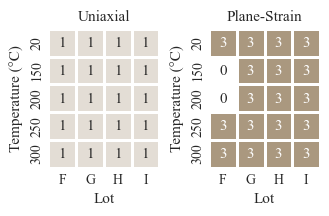

In [10]:
fig, (ut_ax, pst_ax) = plt.subplots(1, 2, figsize=(3.8, 1.8))

pam.experimental_matrix(prepared_ds.subset({'test_type': 'UT'}).info_table, cmap=gold_cmap, ax=ut_ax, vmin=0, vmax=6,
                        index='temperature', columns='lot', as_heatmap=True, xlabel='Lot', ylabel='Temperature (°C)',
                        title='Uniaxial')

pam.experimental_matrix(prepared_ds.subset({'test_type': 'PST'}).info_table, cmap=gold_cmap, ax=pst_ax, vmin=0, vmax=6,
                        index='temperature', columns='lot', as_heatmap=True, xlabel='Lot', ylabel='Temperature (°C)',
                        title='Plane-Strain');

### Visualise the prepared data.

We could colour by lot or by temperature. Colouring by lot is useful to observe variation, colouring by temperature is useful to observe temperature variation.

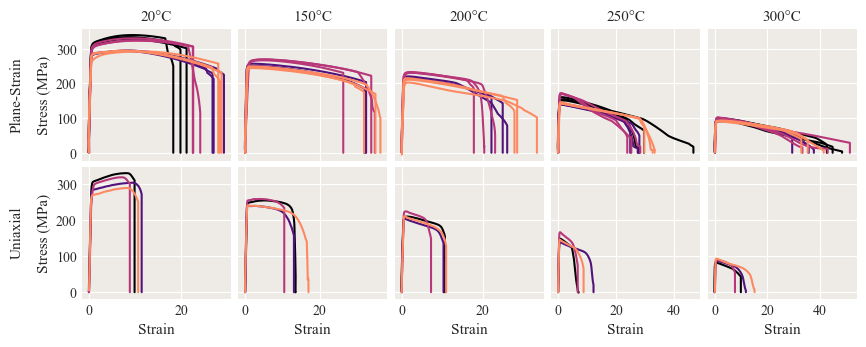

In [11]:
lot_styler = pam.Styler(color_by='lot', color_by_label='Lot', cmap='magma').style_to(prepared_ds)


def ds_subplots(ds: DataSet, **kwargs):
    temperatures = sorted(prepared_ds.info_table['temperature'].unique())
    return pam.plotting.dataset_subplots(
        ds=ds, x='Strain', y='Stress_MPa', xlabel='Strain', ylabel='Stress (MPa)',
        styler=lot_styler.style_to(prepared_ds), plot_legend=False,
        rows_by='test_type', row_vals=[['PST'], ['UT']], row_titles=['Plane-Strain', 'Uniaxial'],
        figsize=(10, 3.5), shape=(2, 5), cols_by='temperature',
        col_vals=[[T] for T in temperatures], col_titles=[f'{T}°C' for T in temperatures], **kwargs,
        subplot_legend=False)


ds_subplots(prepared_ds);

### UTS, failure point

In [12]:
def find_uts(di: DataItem):
    di.info['UTS_0'] = di.data['Strain'].iloc[di.data['Stress_MPa'].idxmax()]
    di.info['UTS_1'] = di.data['Stress_MPa'].max()
    return di


def find_fracture(di: DataItem):
    di.info['FP_0'] = di.data['Strain'].max()
    return di


props_ds = prepared_ds.apply(find_uts).apply(find_fracture)

### Trimming

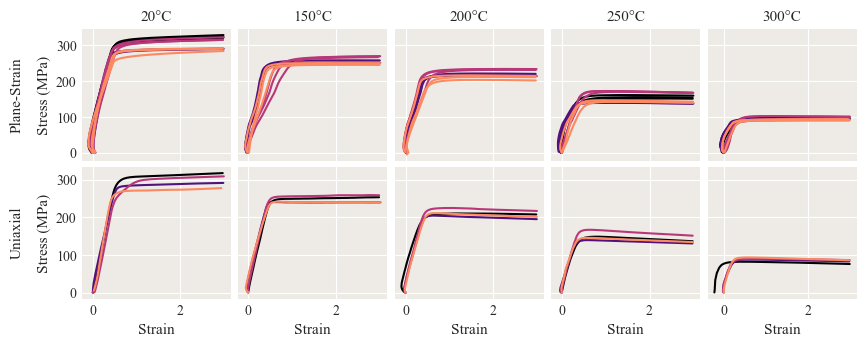

In [13]:
def trim_to_small_strain(di: DataItem):
    di.data = di.data[di.data['Strain'] < 3]
    return di


trimmed_ds = props_ds.apply(trim_to_small_strain)
ds_subplots(trimmed_ds);

### Foot correction, Young's modulus

In [14]:
corrected_ds = pam.find_upl_and_lpl(trimmed_ds, preload=36, preload_key='Stress_MPa')
corrected_ds = pam.correct_foot(corrected_ds)

In [15]:
corrected_ds.write_output('info/02 processed info.xlsx', 'data/02 processed data')
processed_ds = DataSet('info/02 processed info.xlsx', 'data/02 processed data')

### Mechanical Properties

In [16]:
table = pam.make_representative_info(ds=processed_ds, group_by_keys=['temperature', 'test_type'],
                                     group_info_cols=['E', 'UPL_0', 'UPL_1', 'UTS_0', 'UTS_1', 'FP_0'])
table = table[
    ['temperature', 'test_type', 'nr averaged', 'E', 'UPL_0', 'UPL_1', 'UTS_0', 'UTS_1', 'FP_0', 'std_E', 'std_UPL_0', 'std_UPL_1',
     'std_UTS_0', 'std_UTS_1', 'std_FP_0']].style.hide(axis='index').to_latex('info/04 properties.tex')

### Fitted model curves

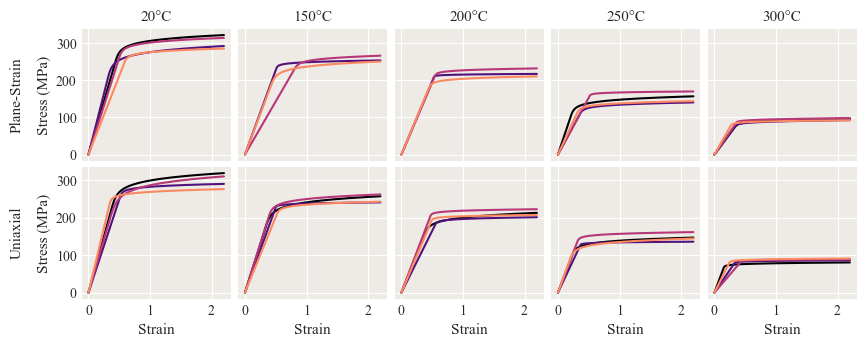

In [17]:
pam.make_representative_data(processed_ds, 'info/03 repres info.xlsx', 'data/03 repres data',
                             repres_col='Stress_MPa', group_by_keys=['lot', 'temperature', 'test_type', 'rate'],
                             interp_by='Strain', group_info_cols=['E', 'UPL_1'])
repr_ds = DataSet('info/03 repres info.xlsx', 'data/03 repres data', test_id_key='repres_id')

ramberg_ms = ModelSet(ramberg, param_names=['C', 'n'], var_names=['E', 'UPL_1'],
                      bounds=[(0., 1000.), (0.1, 0.8)], scipy_func='minimize')

ramberg_ms.fit_to(repr_ds, 'Strain', 'Stress_MPa', sample_size=40)
ramberg_ds = ramberg_ms.predict(xmin=0, xmax=2.2)
ds_subplots(ramberg_ds);

### Fitting results

In [18]:
table = pam.make_representative_info(ramberg_ds, group_by_keys=['temperature', 'test_type'],
                                     group_info_cols=['E', 'UPL_1', 'C', 'n', 'error'])
table[['test_type', 'temperature', 'nr averaged', 'E', 'UPL_1', 'C', 'n',
       'error']].style.hide(axis='index').to_latex('info/05 fitting results.tex')